# **Facial Expression Recognition**

**This Notebook releate to build a CNN model to acurately categorize 7 type of human facial expression
which are [sad, happy, disgust, angry, neutral, fear, surprise]**


**Importing Modules**

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import utils
import os
%matplotlib inline

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Flatten, Dense, Reshape, Multiply, Add,UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import tensorflow as tf
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.13.0


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

**Load and Explore the Dataset**

In [5]:
data_path = 'face_df/CK+48'
data_dir_list = os.listdir(data_path)

img_rows=256
img_cols=256
num_channel=1

num_epoch=10

img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-anger

Loaded the images of dataset-contempt

Loaded the images of dataset-disgust

Loaded the images of dataset-fear

Loaded the images of dataset-happy

Loaded the images of dataset-sadness

Loaded the images of dataset-surprise



(981, 48, 48, 3)

In [6]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:248]=0 #249
labels[249:323]=1 #75
labels[324:407]=2 #84
labels[408:584]=3 #177
labels[585:638]=4 #54
labels[639:845]=5 #207
labels[846:980]=6 #135

names = ['surprise','fear','sadness','disgust' ,'contempt','happy','anger']

def getLabel(id):
    return ['surprise','fear','sadness','disgust' ,'contempt','happy','anger'][id]

In [7]:
from keras.utils import to_categorical
Y = to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=2)
x_test=X_test

**Augmentation and Preprocessing**

In [8]:
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers
import numpy as np


class StandardizedConv2DWithOverride(layers.Conv2D):
    def convolution_op(self, inputs, kernel):
        mean, var = tf.nn.moments(kernel, axes=[0, 1, 2], keepdims=True)
        return tf.nn.conv2d(
            inputs,
            (kernel - mean) / tf.sqrt(var + 1e-10),
            padding="VALID",
            strides=list(self.strides),
            name=self.__class__.__name__,
        )

**Build the CNN Model**

In [9]:
# Inputs
input_layer = Input((48,48,3))

# Encoder
f1=StandardizedConv2DWithOverride(32, kernel_size=3, strides=3, padding='same', activation='relu')(input_layer)
f1=BatchNormalization()(f1)
f=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=MaxPooling2D(2,2)(f)
f2=Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu')(f)


f1=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f1=Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(f1)

f=concatenate([f,f1])
f=BatchNormalization()(f)

f1=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu',name='BeforeFinal_Layer')(f)
f=MaxPooling2D(2,2)(f)
f3=Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu')(f)


f1=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f1=Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(f1)

f=concatenate([f,f1,f2])
f=BatchNormalization()(f)
                    
f1=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=MaxPooling2D(2,2)(f)
f4=Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu')(f)

f1=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f1=Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(f1)
f1=BatchNormalization()(f1)

f=concatenate([f,f1,f3])

f1=Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=MaxPooling2D(2,2)(f)


f1=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f1=Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu')(f1)
f1=BatchNormalization()(f1)

f=concatenate([f,f1,f4])
#f=BatchNormalization()(f)
f=Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu', name='Final_Layer')(f)
#f=Conv2D(512, kernel_size=1, strides=2, padding='same', activation='relu')(f)
f=BatchNormalization()(f)
                    
f= Flatten()(f)
f=Dropout(rate=0.3)(f)
#f=BatchNormalization()(f)
f=Dense(1024, activation='relu')(f)
f=Dropout(rate=0.32)(f)
#f=BatchNormalization()(f)
output_layer=Dense(7, activation='softmax')(f)

# Model
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)
model.summary()

from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='model.png', show_shapes=True)
Image("model.png")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 standardized_conv2d_with_o  (None, 16, 16, 32)           896       ['input_1[0][0]']             
 verride (StandardizedConv2                                                                       
 DWithOverride)                                                                                   
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 32)           128       ['standardized_conv2d_with_ove
 Normalization)                                                     rride[0][0]']             

 conv2d_20 (Conv2D)          (None, 1, 1, 256)            147712    ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 1, 1, 256)            0         ['conv2d_18[0][0]']           
 g2D)                                                                                             
                                                                                                  
 batch_normalization_4 (Bat  (None, 1, 1, 256)            1024      ['conv2d_20[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 conv2d_13 (Conv2D)          (None, 1, 1, 32)             4128      ['max_pooling2d_2[0][0]']     
                                                                                                  
 concatena

FileNotFoundError: No such file or directory: 'model.png'

FileNotFoundError: No such file or directory: 'model.png'

<IPython.core.display.Image object>

**Training and Saving the Model**

In [10]:
input_shape=(48,48,3)

#model = Sequential()
#model.add(model)

In [13]:
IMAGE_SIZE=(48,48)
from keras.preprocessing import image
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}
from keras.callbacks import Callback
import cv2

class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        #img = cv2.imread("/kaggle/input/fer2013/test/surprise/PrivateTest_10089743.jpg")
        #img = cv2.resize(img ,IMAGE_SIZE)
        img = image.load_img("face_df/CK+48/anger/S010_004_00000017.png",target_size = (48,48),color_mode = "grayscale")
        img = np.array(img)
        

        #img = img / 255
        #img = img[np.newaxis, :, :, :]
        #pred=model.predict(img)
        img1 = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
        img2 = img1.reshape(1,48,48,3)
        result = model.predict(img2)
        result = list(result[0])
        img_index = result.index(max(result))
        label=label_dict[img_index]
        

        exp = GradCAM()
        cam = exp.explain(
            validation_data=(img2, result), 
            class_index=1,
            layer_name='Final_Layer', 
            model=self.model
            )

        plt.figure(figsize=(5,2))
        plt.subplot(1,2,1)
        plt.imshow(np.squeeze(img))
        plt.title('Original Image')

        plt.subplot(1,2,2)
        plt.title('GradCAM')
        plt.imshow(cam)
        plt.tight_layout()
        plt.show()
        print("***************************Predicted label: ",label)

In [20]:
epochs = 50


learning_rate = 1e-3
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#checkpoint = ModelCheckpoint("model_weights.h5", monitor="val_accuracy", save_weights_only=True, mode='max', verbose=1)

#reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.1, patience = 2, min_lr=0.00001, model='auto')

callbacks = [ModelCheckpoint('fd_model.h5',monitor="val_accuracy", verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, verbose=1, min_lr=1e-6),
            #ShowProgress(),
            EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=100)]

history = hist = model.fit(X_train, y_train, batch_size=7, epochs=epochs, verbose=1, validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/50
119/119 [==============================] - ETA: 0s - loss: 0.2888 - accuracy: 0.9124
Epoch 1: val_accuracy improved from -inf to 0.85811, saving model to fd_model.h5
119/119 [==============================] - 19s 125ms/step - loss: 0.2888 - accuracy: 0.9124 - val_loss: 0.7167 - val_accuracy: 0.8581 - lr: 0.0010
Epoch 2/50
119/119 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.9220
Epoch 2: val_accuracy improved from 0.85811 to 0.87162, saving model to fd_model.h5
119/119 [==============================] - 16s 130ms/step - loss: 0.3435 - accuracy: 0.9220 - val_loss: 0.9523 - val_accuracy: 0.8716 - lr: 0.0010
Epoch 3/50
119/119 [==============================] - ETA: 0s - loss: 0.2419 - accuracy: 0.9364
Epoch 3: val_accuracy improved from 0.87162 to 0.88514, saving model to fd_model.h5
119/119 [==============================] - 15s 127ms/step - loss: 0.2419 - accuracy: 0.9364 - val_loss: 0.7799 - val_accuracy: 0.8851 - lr: 0.0010
Epoch 4/50
119/119 [==

119/119 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9376
Epoch 28: val_accuracy did not improve from 0.92568
119/119 [==============================] - 15s 130ms/step - loss: 0.2251 - accuracy: 0.9376 - val_loss: 45.6840 - val_accuracy: 0.6081 - lr: 0.0010
Epoch 29/50
119/119 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.9604
Epoch 29: val_accuracy did not improve from 0.92568
119/119 [==============================] - 16s 134ms/step - loss: 0.1392 - accuracy: 0.9604 - val_loss: 0.5224 - val_accuracy: 0.9122 - lr: 0.0010
Epoch 30/50
119/119 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9796
Epoch 30: val_accuracy did not improve from 0.92568
119/119 [==============================] - 16s 132ms/step - loss: 0.0740 - accuracy: 0.9796 - val_loss: 0.8486 - val_accuracy: 0.8986 - lr: 0.0010
Epoch 31/50
119/119 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9688
Epoch 31: val_accuracy did

<Figure size 2000x1000 with 0 Axes>

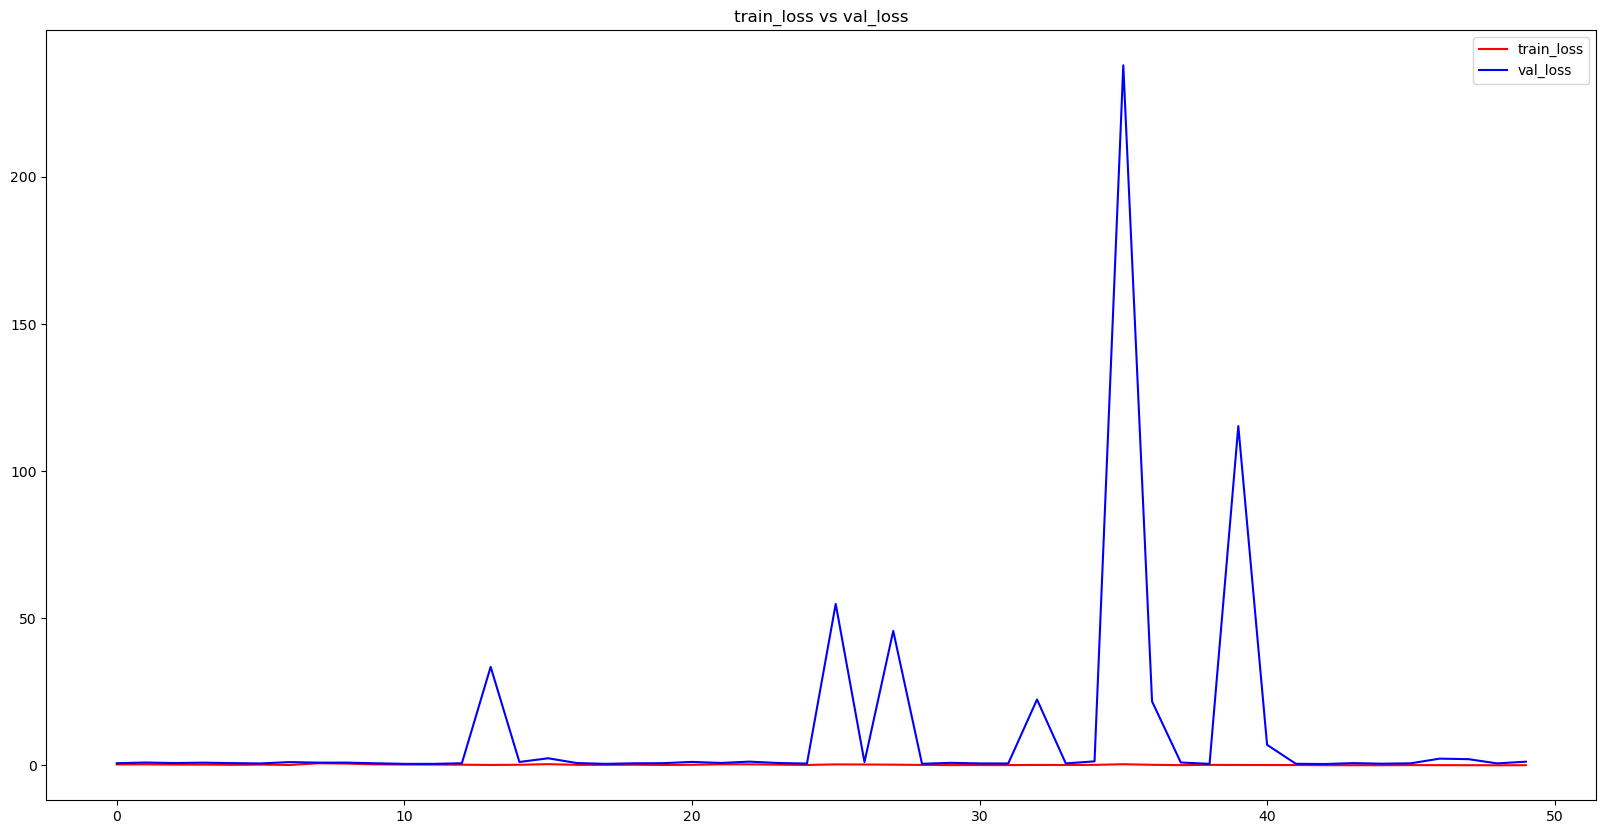

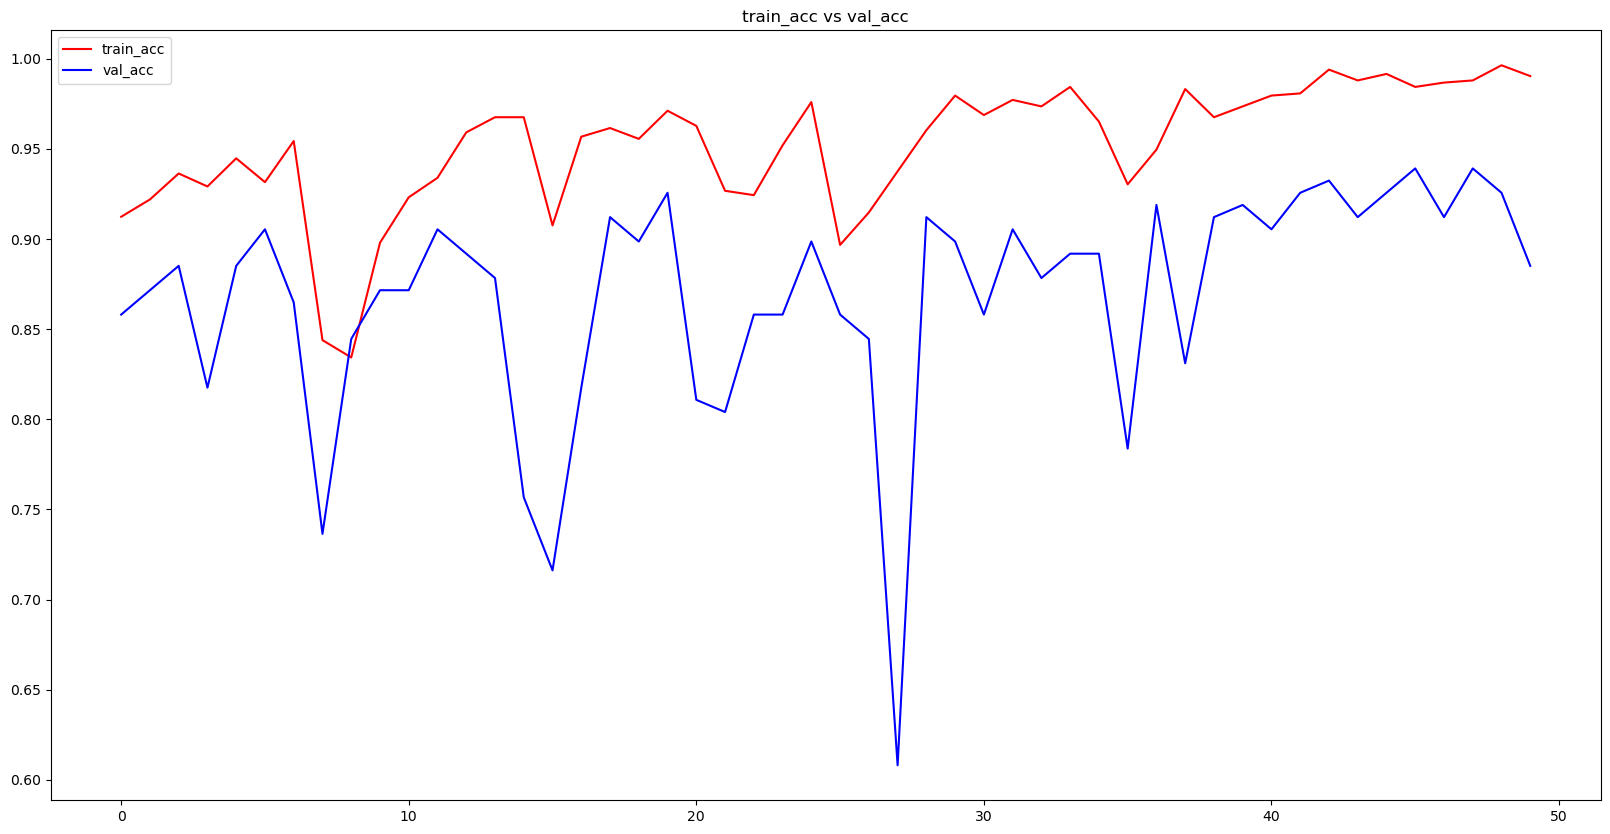

<Figure size 2000x1000 with 0 Axes>

In [21]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

In [25]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 1.2303736209869385
Test accuracy: 0.8851351141929626


5/5 [==============================] - 0s 30ms/step


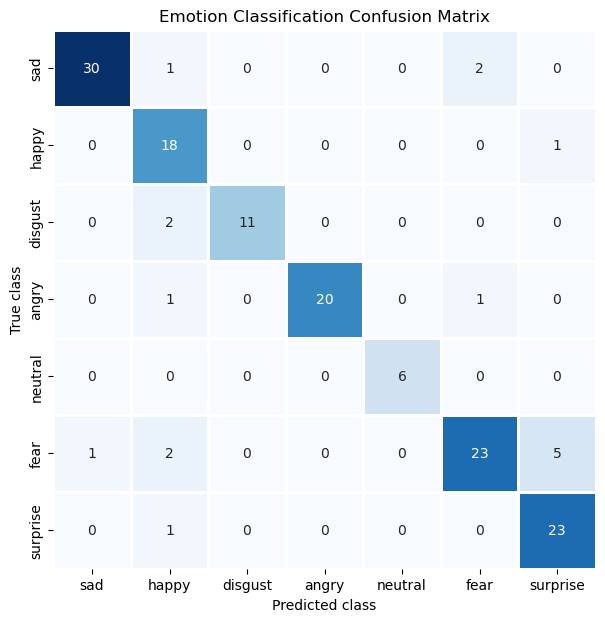

In [23]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your model is a functional model
results = model.predict(X_test)

# Convert probabilities to class labels by selecting the index of the highest probability
predicted_classes = np.argmax(results, axis=1)

# Assuming y_test contains one-hot encoded labels, convert it to single labels
y_true = np.argmax(y_test, axis=1)

# Define your emotion labels in the desired order
label = ['sad', 'happy', 'disgust', 'angry', 'neutral', 'fear', 'surprise']

# Define the mapping of class indices to emotion labels
labels = {0: 'sad', 1: 'happy', 2: 'disgust', 3: 'angry', 4: 'neutral', 5: 'fear', 6: 'surprise'}

# Calculate the confusion matrix
cm = confusion_matrix(y_true, predicted_classes)

# Transform to DataFrame for easier plotting
cm_df = pd.DataFrame(cm, index=label, columns=label)

# Create a heatmap with a white-blue color palette ('Blues')
plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', cbar=False, linewidth=2, fmt='d')
plt.title('Emotion Classification Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


In [24]:
from sklearn.metrics import classification_report

# Assuming you have 'y_true' (true labels) and 'predicted_classes' (predicted labels)
# 'target_names' is a list of class names in the same order as your labels
target_names = ['sad', 'happy', 'disgust', 'angry', 'neutral', 'fear', 'surprise']

# Generate the classification report
report = classification_report(y_true, predicted_classes, target_names=target_names)

# Print the classification report
print(report)


              precision    recall  f1-score   support

         sad       0.97      0.91      0.94        33
       happy       0.72      0.95      0.82        19
     disgust       1.00      0.85      0.92        13
       angry       1.00      0.91      0.95        22
     neutral       1.00      1.00      1.00         6
        fear       0.88      0.74      0.81        31
    surprise       0.79      0.96      0.87        24

    accuracy                           0.89       148
   macro avg       0.91      0.90      0.90       148
weighted avg       0.90      0.89      0.89       148



In [32]:
class StandardizedConv2DWithOverride(layers.Conv2D):
    def __init__(self, *args, **kwargs):
        super(StandardizedConv2DWithOverride, self).__init__(*args, **kwargs)

    def convolution_op(self, inputs, kernel):
        mean, var = tf.nn.moments(kernel, axes=[0, 1, 2], keepdims=True)
        return tf.nn.conv2d(
            inputs,
            (kernel - mean) / tf.sqrt(var + 1e-10),
            padding="VALID",
            strides=list(self.strides),
            name=self.__class__.__name__,
        )

In [39]:
import cv2
import numpy as np
import tensorflow
from tensorflow.keras.models import load_model

tf.keras.utils.get_custom_objects()['StandardizedConv2DWithOverride'] = StandardizedConv2DWithOverride

model = load_model('fd_model.h5')


In [ ]:
image='photo.jpg'

In [ ]:
import cv2
cv2.imread(image)